In [1]:
import scvi

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import os
import anndata
import jax
import seaborn as sns
from matplotlib.pyplot import rc_context

Read Tumor_f (Quantile and mt.percent filtered) no doublets and Ambient RNA removed (anndata created through Rstudio using sceasy)

In [4]:
setwd = "/home/users/astar/bii/caminorsm/PDSC_SC/SARC/"

In [5]:
Tumor = anndata.read_h5ad(os.path.join(setwd,"Tumor_anndata.h5ad"))

In [6]:
palette = ["#E31A1C", "#1F78B4", "#A6CEE3",  "#B2DF8A", "#33A02C", "#FB9A99",  "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928", "#66C2A5",
               "#FC8D62", "#8DA0CB", "#B3B3B3", "#A6D854", "#FFD92F", "#E5C494", "#E78AC3",
           '#f90492', '#f7d048', '#098474', '#505ba7', '#927306', '#6a5247']

In [7]:
print(Tumor)

AnnData object with n_obs × n_vars = 24271 × 25644
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.score', 'biosample', 'patient', 'Enrichment', 'biopsy_location', 'MDM2_FISH....amplification.', 'MDM2_FISH..MDM2.CEP12.ratio.', 'Chemo1_Type', 'Sex', 'Age_of_first_Diagnosis', 'Race', 'Sarcoma_type', 'Grade_of_first_diagnosis', 'Tumor_size', 'X.WD', 'X.DD', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'mapping.score', 'harmony_cluster'
    var: 'name'
    obsm: 'X_harmony', 'X_integrated_dr', 'X_pca', 'X_ref.umap', 'X_umap.harmony'


In [8]:
print('Total number of cells: {:d}'.format(Tumor.n_obs))
print('Total number of genes: {:d}'.format(Tumor.n_vars))
print('Total number of donors: {:d}'.format(len(set(Tumor.obs["orig.ident"]))))

Total number of cells: 24271
Total number of genes: 25644
Total number of donors: 5


### Identify HVGs and subset before scVI (2k genes) --> you can subset HSP/VDJ/Bcell genes if necessary too

In [9]:
# Calculate hvg genes
sc.pp.highly_variable_genes(
    Tumor,
    n_top_genes=2000,
    subset=False,
    flavor="seurat_v3",
    batch_key="orig.ident"
)

In [10]:
hvg_genes = Tumor.var.index[Tumor.var['highly_variable']]

In [11]:
# Filter VDJ and HSP genes

# Check for VDJ genes (e.g., "IGH", "IGK", "TRAV", etc.)
vdj_genes = [gene for gene in hvg_genes if any(prefix in gene for prefix in ["IGH", "IGK", "IGL", "TRA", "TRB", "TRD", "TRG"])]
print(f"VDJ genes: {vdj_genes}")

# Check for HSP genes (e.g., "HSP")
hsp_genes = [gene for gene in hvg_genes if "HSP" in gene.upper()]
print(f"HSP genes: {hsp_genes}")

VDJ genes: ['TRABD2B', 'IGKC', 'IGKV4-1', 'IGKV1-5', 'IGKV3-20', 'IGKV1-39', 'HTRA3', 'TRBV28', 'TRBC1', 'TRBC2', 'TRAPPC9', 'TRAF1', 'TRD-AS1', 'IGHG4', 'IGHA1', 'IGHG1', 'IGHG3', 'IGHM', 'IGHV3-23', 'IGHV1-24', 'IGHV3-30', 'IGHV4-34', 'IGHV4-39', 'IGLV1-40', 'IGLV2-14', 'IGLV3-1', 'IGLL5', 'IGLC2', 'IGLC3']
HSP genes: ['HSPA6', 'HSPB3', 'HSPA1A', 'HSPA1B', 'HSPA5', 'HSPH1', 'CARHSP1']


In [12]:
# Combine VDJ and HSP genes into a single list
genes_to_remove = set(vdj_genes + hsp_genes)

# Filter HVGs by removing VDJ and HSP genes
filtered_hvg_genes = [gene for gene in hvg_genes if gene not in genes_to_remove]

# Update the 'highly_variable' column in Tumor.var
Tumor.var['highly_variable'] = Tumor.var.index.isin(filtered_hvg_genes)

print(f"Number of HVGs after filtering: {Tumor.var['highly_variable'].sum()}")


Number of HVGs after filtering: 1964


Make a copy of initial object and set layers as "counts"

In [13]:
bdata = Tumor[:, Tumor.var.index.isin(filtered_hvg_genes)].copy()

bdata.layers['counts'] = bdata.X.copy()


## Recheck number of genes

In [14]:
print('Total number of genes in initial object: {:d}'.format(Tumor.n_vars))
print('Total number of highly_variable genes: {:d}'.format(bdata.n_vars))

Total number of genes in initial object: 25644
Total number of highly_variable genes: 1964


Transform to sparse matrix for faster modelling

In [15]:
bdata.X = bdata.X.tocsr()
print(bdata.layers)

Layers with keys: counts


optional - remove weird characters from the column names 

In [16]:
## replace dot in orig.ident with "_"
bdata.obs.rename(columns={'orig.ident': 'orig_ident'}, inplace=True)
set(bdata.obs)

{'Age_of_first_Diagnosis',
 'Chemo1_Type',
 'Enrichment',
 'Grade_of_first_diagnosis',
 'HTO_classification',
 'HTO_classification.global',
 'HTO_margin',
 'HTO_maxID',
 'HTO_secondID',
 'MDM2_FISH....amplification.',
 'MDM2_FISH..MDM2.CEP12.ratio.',
 'Race',
 'SCT_snn_res.0.5',
 'Sarcoma_type',
 'Sex',
 'Tumor_size',
 'X.DD',
 'X.WD',
 'biopsy_location',
 'biosample',
 'harmony_cluster',
 'hash.ID',
 'mapping.score',
 'nCount_HTO',
 'nCount_RNA',
 'nCount_SCT',
 'nCount_original.counts',
 'nFeature_HTO',
 'nFeature_RNA',
 'nFeature_SCT',
 'nFeature_original.counts',
 'orig_ident',
 'patient',
 'percent.mt',
 'predicted.celltype.l1',
 'predicted.celltype.l1.score',
 'predicted.celltype.l2',
 'predicted.celltype.l2.score',
 'scDblFinder.score',
 'seurat_clusters'}

Setup covariates (categorical/continuous) for correction ## in order to later map p0/p4 only batch_key!! mapping is not allowed with other covariates!!

In [17]:
scvi.model.SCVI.setup_anndata(bdata,layer="counts",batch_key="orig_ident")

/home/users/astar/bii/caminorsm/.local/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [18]:
model = scvi.model.SCVI(bdata)
print(model)

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [19]:
model2 = scvi.model.SCVI(bdata, n_layers=2, n_latent=32)
print(model2)

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 32, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [20]:
model.train(check_val_every_n_epoch=10,early_stopping=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/users/astar/bii/caminorsm/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/users/astar/bii/caminorsm/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Training:   0%|          | 0/330 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=330` reached.


In [21]:
model2.train(check_val_every_n_epoch=10, early_stopping=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/users/astar/bii/caminorsm/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/home/users/astar/bii/caminorsm/.local/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Training:   0%|          | 0/330 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=330` reached.


In [22]:
model.save("/home/users/astar/bii/caminorsm/PDSC_SC/SARC/Tumor/model_1/")
model2.save("/home/users/astar/bii/caminorsm/PDSC_SC/SARC/Tumor/model_2/")
bdata.write("/home/users/astar/bii/caminorsm/PDSC_SC/SARC/Tumor/model_1/bdata_model1.h5ad")
bdata.write("/home/users/astar/bii/caminorsm/PDSC_SC/SARC/Tumor/model_2/bdata_model2.h5ad")


In [23]:
y = model2.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()

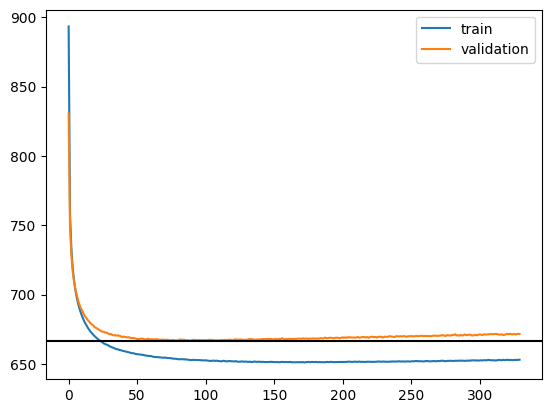

In [24]:
plt.plot(model2.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(model2.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')

plt.axhline(y, c = 'k')

plt.legend()
plt.show()

In [25]:
x = model.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()

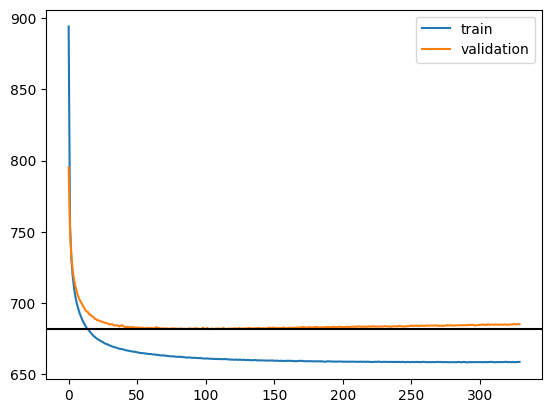

In [26]:
plt.plot(model.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train')
plt.plot(model.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation')

plt.axhline(x, c = 'k')

plt.legend()
plt.show()

## Although both models look pretty similar, model model looks the less overfitted... I will continue with model model

In [27]:
latent = model.get_latent_representation()

In [28]:
Tumor.obsm["X_scVI"] = latent

In [29]:
sc.pp.neighbors(Tumor, use_rep="X_scVI")
sc.tl.leiden(Tumor, key_added="leiden_scvi", resolution=0.5)
sc.tl.umap(Tumor, min_dist=0.4)

/tmp/ipykernel_1491596/3691088943.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(Tumor, key_added="leiden_scvi", resolution=0.5)


In [57]:
palette = ["#E31A1C", "#1F78B4", "#A6CEE3",  "#B2DF8A", "#33A02C", "#FB9A99",  "#FDBF6F", "#FF7F00", "#CAB2D6", "#6A3D9A", "#FFFF99", "#B15928", "#66C2A5",
               "#FC8D62", "#8DA0CB", "#B3B3B3", "#A6D854", "#FFD92F", "#E5C494", "#E78AC3",
           '#f90492', '#f7d048', '#098474', '#505ba7', '#927306', '#6a5247']

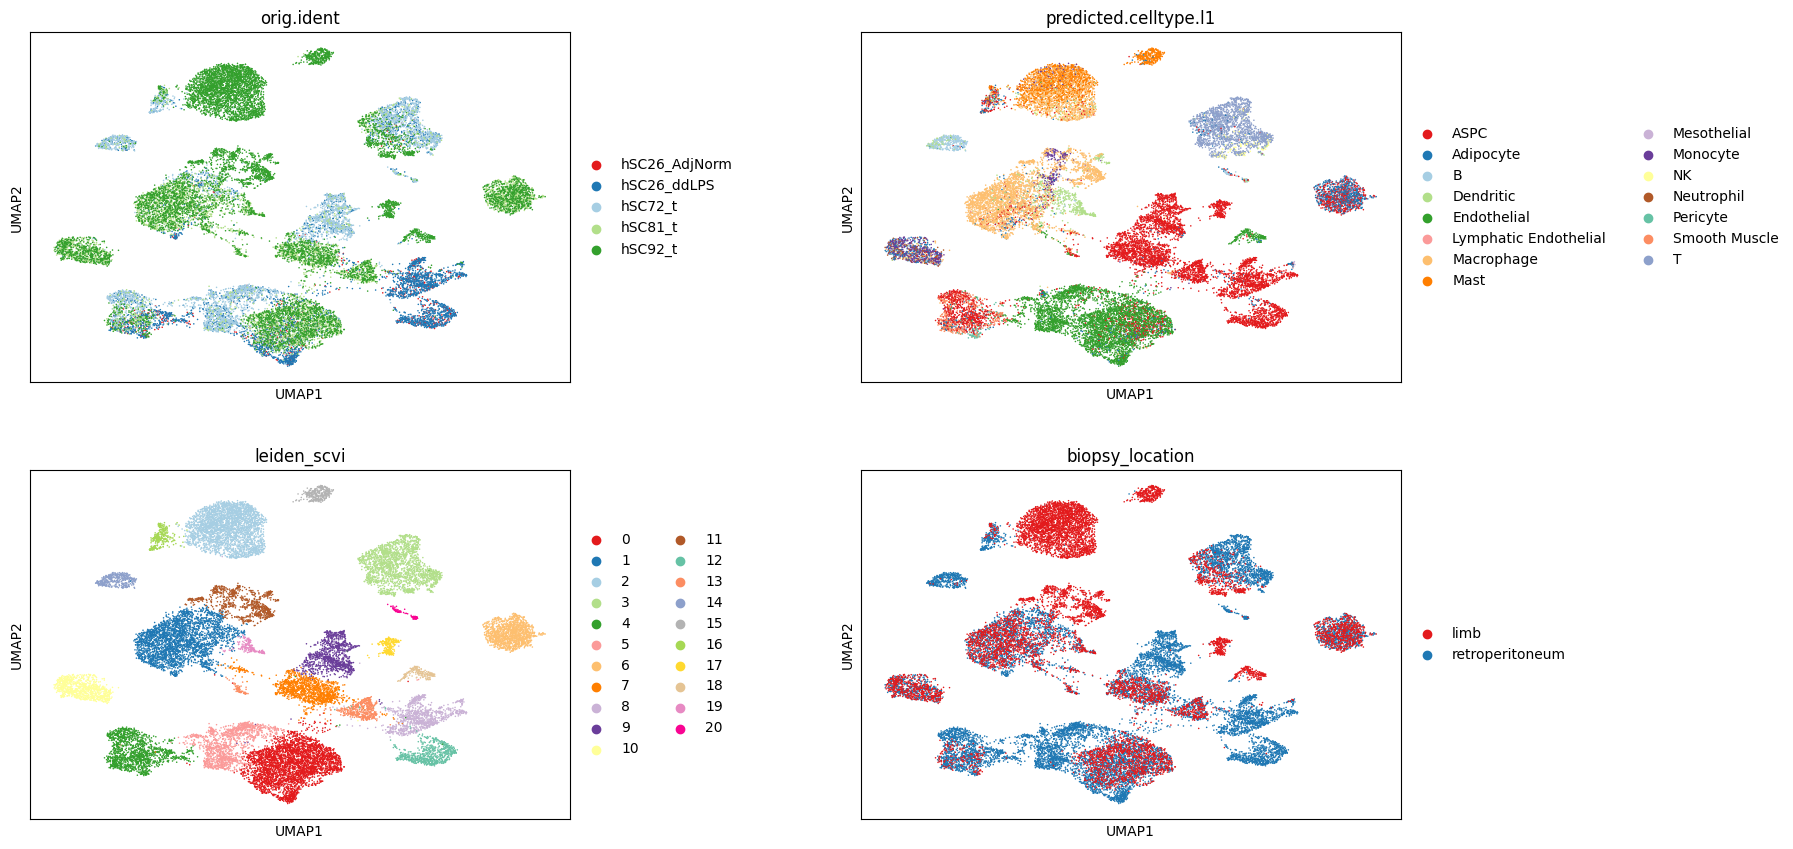

In [32]:
np.random.seed(1)
ri = np.random.permutation(list(range(Tumor.shape[0])))
sc.pl.umap(
    Tumor,
    color=['orig.ident','predicted.celltype.l1','leiden_scvi','biopsy_location'], 
    palette = palette,
    frameon=True, ncols = 2, wspace = 0.4)


In [33]:
Tumor.layers['counts'] = Tumor.X.copy()

In [34]:
sc.pp.normalize_total(Tumor)

In [35]:
sc.pp.log1p(Tumor)

In [36]:
print(Tumor.var.columns)

Index(['name', 'highly_variable', 'highly_variable_rank', 'means', 'variances',
       'variances_norm', 'highly_variable_nbatches'],
      dtype='object')


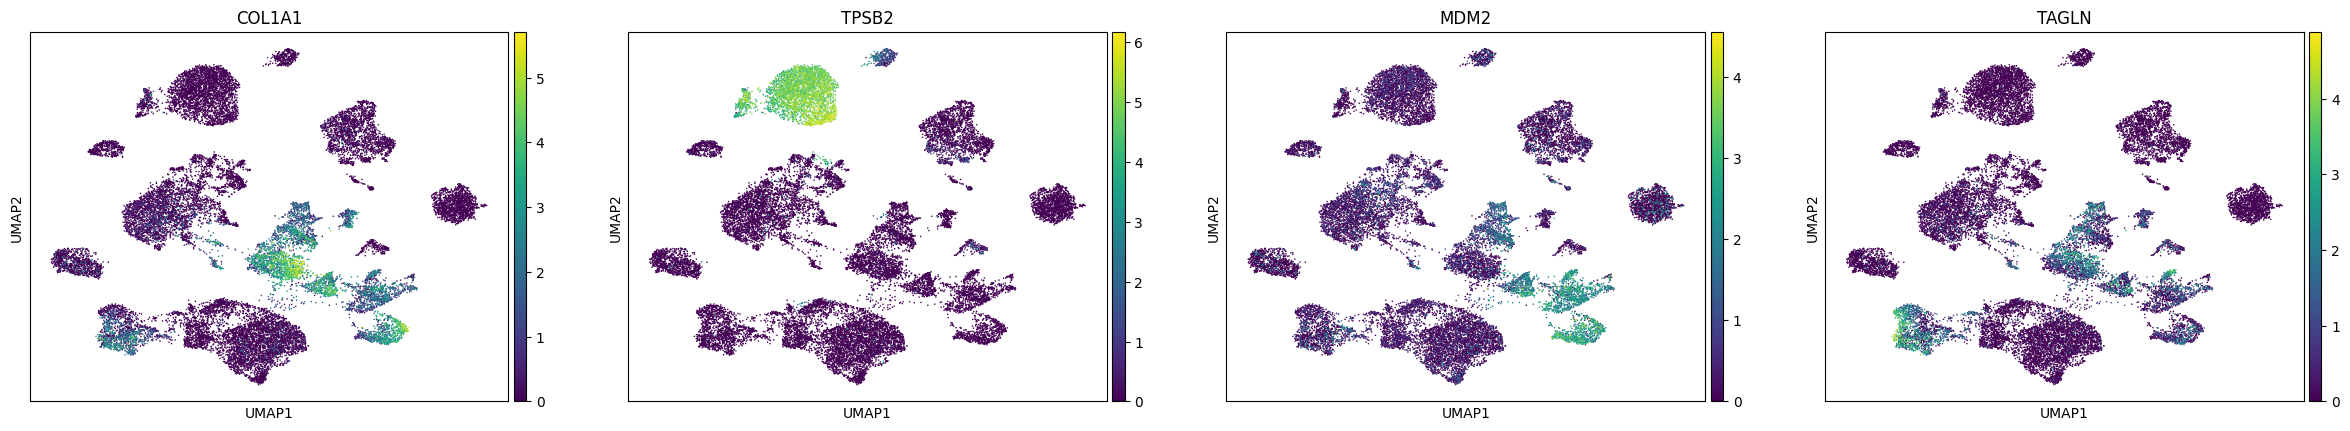

In [38]:
sc.pl.umap(Tumor, color=("COL1A1","TPSB2","MDM2","TAGLN"))

In [50]:
Tumor

AnnData object with n_obs × n_vars = 24271 × 25644
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'nCount_original.counts', 'nFeature_original.counts', 'scDblFinder.score', 'biosample', 'patient', 'Enrichment', 'biopsy_location', 'MDM2_FISH....amplification.', 'MDM2_FISH..MDM2.CEP12.ratio.', 'Chemo1_Type', 'Sex', 'Age_of_first_Diagnosis', 'Race', 'Sarcoma_type', 'Grade_of_first_diagnosis', 'Tumor_size', 'X.WD', 'X.DD', 'predicted.celltype.l1.score', 'predicted.celltype.l1', 'predicted.celltype.l2.score', 'predicted.celltype.l2', 'mapping.score', 'harmony_cluster', 'leiden_scvi'
    var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'neighbors', 'leiden_scvi', 'umap', 'orig.ident_c

In [36]:
Tumor.write("/home/users/astar/bii/caminorsm/PDSC_SC/Tumor/Tumor_anndata_SCVI.h5ad")

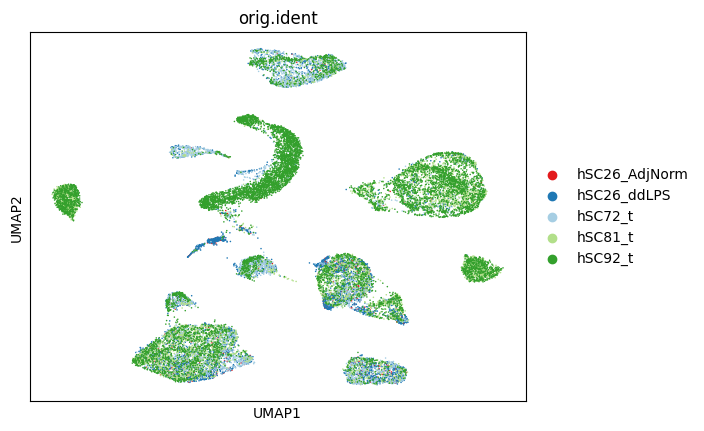

In [52]:
Tumor.obsm['X_umap'] = Tumor.obsm['X_umap.harmony'] 
np.random.seed(1)
ri = np.random.permutation(list(range(Tumor.shape[0])))
sc.pl.umap(Tumor, color='orig.ident') 